# PA005: High Value Customer Identification (Insiders)

# 0.0. Imports

In [1]:

from sklearn.manifold import TSNE

from matplotlib          import pyplot        as plt
from sklearn             import cluster       as c
from sklearn             import metrics       as m
from sklearn             import preprocessing as pp
from sklearn             import decomposition as dd
from sklearn             import mixture       as mx
from sklearn             import ensemble      as en

from scipy.cluster      import hierarchy     as hc
from plotly              import express       as px
from pandas_profiling    import ProfileReport

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib 

import re
import pickle
import umap.umap_ as umap


/home/heitor/repos/insiders_clustering/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.2. Helper Functions

In [126]:
%matplotlib inline
def num_attributes(df1):
    
    num_attributes = df1.select_dtypes(['int64', 'float64'])

    #central tendency
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    #dispersion
    d1 = pd.DataFrame(num_attributes.apply(np.min)).T
    d2 = pd.DataFrame(num_attributes.apply(np.max)).T
    d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d4 = pd.DataFrame(num_attributes.apply(np.std)).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    m = pd.concat( [d1, d2, d3, ct1, ct2, d4, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
    return m

## 0.3. Load Data

In [46]:
df_raw = pd.read_csv(r'../data/Ecommerce.csv')


# 1.0. Data Description

In [47]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [48]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [49]:
df1.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

## 1.2. Data Shape

In [50]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3. Data Types

In [51]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NAs


In [52]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Fill NAs

In [53]:
#remove na
df_missing = df1[df1['customer_id'].isna()]
df_not_missing = df1[-df1['customer_id'].isna()]



In [54]:
len(df_missing)

135080

In [55]:
len(df_not_missing)

406829

In [56]:
#create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

#merge
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

#coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

#drop extra columns
df1 = df1.drop(['customer_id_x', 'customer_id_y'], axis=1)




In [57]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [58]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [59]:
#invoice_no 
# df1['invoice_no'] = df1['invoice_no'].astype(int)


#stock_code 
# df1['stock_code'] = df1['stock_code'].astype(int)


#invoice_date  --> Month --> b
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format=('%d-%b-%y'))


#customer_id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive statistics

In [60]:

cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [61]:
m1 = num_attributes(df1)
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611121,2.08,96.759763,186.506973,59005.719804
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.7.1.1 Investigating

1. Negative quantity (devolution?)
2. Price = 0 (Promo?)

## 1.7.2. Categorical Attributes

In [62]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


#### Invoice no

In [63]:

#invoice_no -- some of them has one char
df_invoice_char = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]   

len(df_invoice_char[df_invoice_char['quantity']<0])


print('Total of invoices with letter: {}'.format(len(df_invoice_char)))
print('Total of negative quantaty: {}'.format(len(df1[df1['quantity']<0])))
print('Letter means negative quantity')

Total of invoices with letter: 9291
Total of negative quantaty: 10624
Letter means negative quantity


#### Stock Code

In [64]:
#all stock codes with char
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

#remove stock code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
# df1 = df1[-df1.isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])]

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [65]:
df1.head(2) #remove description


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850


#### Country


In [66]:
df1['country'].value_counts(normalize='True').head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [67]:
df1[['country', 'customer_id']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0. Data Filtering

In [68]:
df2 = df1.copy()

In [69]:
 # === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map -  
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df_returns = df2.loc[df1['quantity'] < 0, :]
df_purchase = df2.loc[df1['quantity'] >= 0, :]

# 3.0. Feature Engineering

In [99]:
df3 = df2.copy()

## 3.1. Feature Creation

In [100]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )



### 3.1.1. Gross Revenue

In [101]:
#calculate gross revenue
df_purchase.loc[:,'gross_revenue'] = df_purchase.loc[:, 'quantity'] * df_purchase.loc[:, 'unit_price'] 

#gross revenue by customer
df_monetary = df_purchase.loc[:,['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how= 'left')
df_ref.isna().sum()

len(df_ref)

/tmp/ipykernel_114369/2480933991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_purchase.loc[:,'gross_revenue'] = df_purchase.loc[:, 'quantity'] * df_purchase.loc[:, 'unit_price']


5786

### 3.1.2. Recency - Days from last purchase


In [102]:
#recency 

df_recency = df_purchase.loc[:,['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency  = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
len(df_ref)

5786

### 3.1.4. Quantity of purchase

In [103]:

# Número de compras
df_invoice = df_purchase.loc[:,['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'qt_invoice'})
df_ref = pd.merge(df_ref, df_invoice, on='customer_id', how='left')
len(df_ref)

5786

### 3.1.4. Quantity of products purchase

In [104]:
# Número de compras
df_stock_code = df_purchase.loc[:,['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code':'qt_products'})
df_ref = pd.merge(df_ref, df_stock_code, on='customer_id', how='left')
len(df_ref)


5786

### 3.1.6. Frequency

In [105]:
df_aux = (df_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates().groupby('customer_id').agg(
                                                            max_ = ('invoice_date', 'max'),
                                                            min_ = ('invoice_date', 'min'),
                                                            days = ('invoice_date', lambda x: (x.max() - x.min()).days ),
                                                            buys = ('invoice_no', 'count'))).reset_index()

# #calculate frequency
df_aux['frequency'] = df_aux[['buys', 'days']].apply(lambda x: x['buys']/x['days'] if x['days']!= 0 else 0, axis=1)


#merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')
df_ref.isna().sum()


customer_id       0
gross_revenue    91
recency_days     91
qt_invoice       91
qt_products      91
frequency        91
dtype: int64

### 3.1.7. Returns


In [106]:
df_aux = df_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qt_returns'})
df_aux['qt_returns'] = -1*df_aux['qt_returns']
df_aux['qt_returns'] = df_aux['qt_returns'].fillna(0)
#merge
df_ref = pd.merge(df_ref, df_aux, on='customer_id', how='left')



In [107]:
df_ref.loc[df_ref['qt_returns'].isna(), 'qt_returns'] = 0
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qt_invoice       91
qt_products      91
frequency        91
qt_returns        0
dtype: int64

# 4.0. Exploratory Data Analisys

In [259]:
df4 = df_ref.dropna()


## 4.3. Estudo do Espaço

In [260]:
# selected dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qt_products', 'frequency', 'qt_returns']
df43 = df4[ cols_selected ].drop( columns='customer_id', axis=1 ).copy() 

In [261]:
mm = pp.MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days']  = mm.fit_transform( df43[['recency_days']] )
df43['qt_products'] = mm.fit_transform( df43[['qt_products']])
df43['frequency']     = mm.fit_transform( df43[['frequency']])
df43['qt_returns']  = mm.fit_transform( df43[['qt_returns']])

### 4.3.4. Tree-Based Embedding

In [168]:
en.RandomForestRegressor?

In [199]:



#training dataset
X = df4.drop(['gross_revenue','customer_id'], axis=1)
y = df4['gross_revenue']

#model definition
rf_model = en.RandomForestRegressor(random_state=42, n_estimators=100)

#model training
rf_model.fit(X,y)



# dataframe leaf
df_leaf = pd.DataFrame(rf_model.apply(X))
# df_leaf = pickle.load(open('../data/df_leaf.pkl', 'rb'))

In [200]:
reducer = umap.UMAP( random_state=42)
embedding = reducer.fit_transform(df_leaf)

df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]



/home/heitor/repos/insiders_clustering/venv/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [201]:
X = df_tree.copy()

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

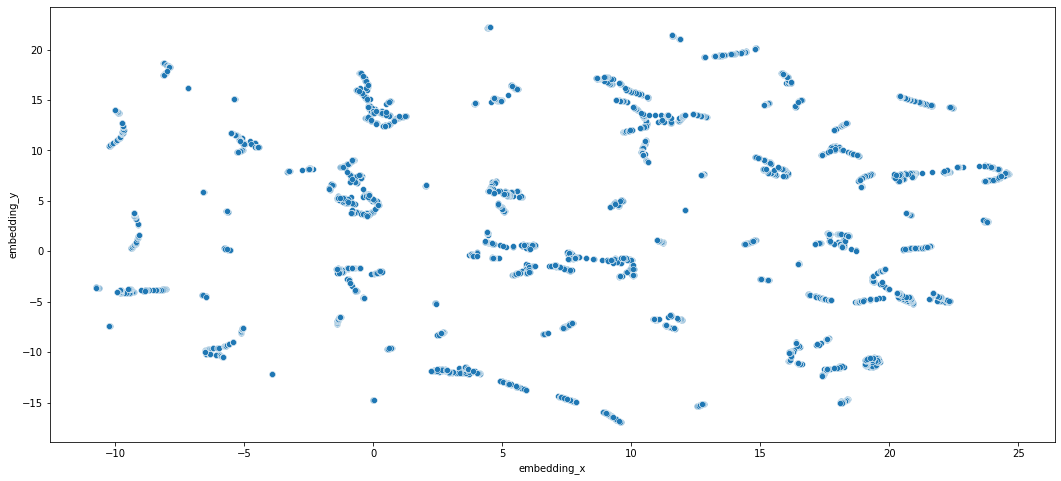

In [202]:

plt.figure(figsize=(18,8));
sns.scatterplot(x='embedding_x', y='embedding_y',data=df_tree)

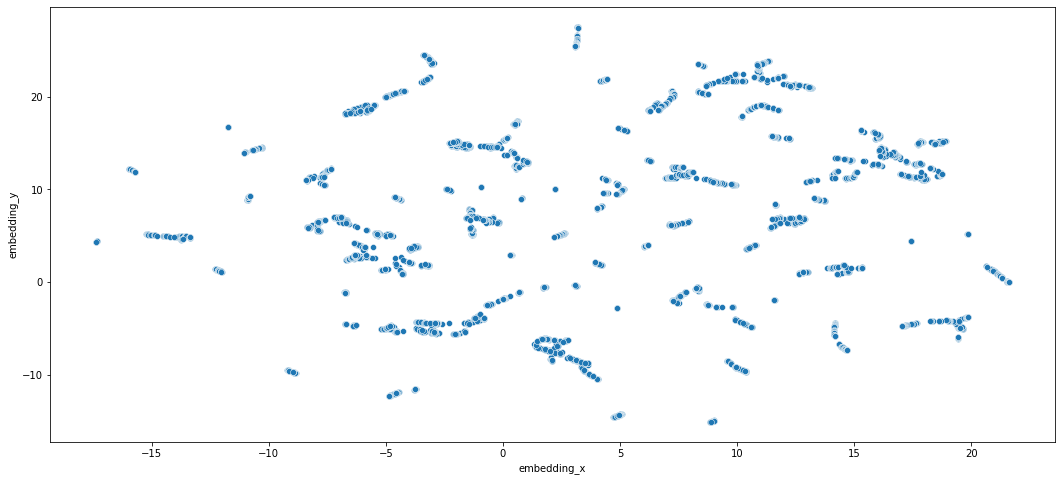

In [185]:

plt.figure(figsize=(18,8));
sns.scatterplot(x='embedding_x', y='embedding_y',data=df_tree);

In [148]:
df_tree.shape

(5695, 2)

# 7.0. Hyperparameter Fine-Tunning

In [250]:
X = df43.copy()
X.head()

,gross_revenue,recency_days,qt_products,frequency,qt_returns
0,0.019312,0.997319,0.037770,1.000000,0.000539
1,0.011579,0.150134,0.021692,0.000835,0.000472
2,0.024020,0.005362,0.029476,0.001189,0.000674
3,0.003396,0.254692,0.003445,0.000529,0.000000
4,0.003137,0.892761,0.000255,0.002206,0.000296


In [238]:
clusters = np.arange(2,11, 1)

kmeans_list = []
for k in clusters:

    #model definition
    kmeans_model = c.KMeans(n_clusters=k, random_state=42)

    #model training
    kmeans_model.fit(X)

    #model predict
    labels = kmeans_model.predict(X)

    #model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

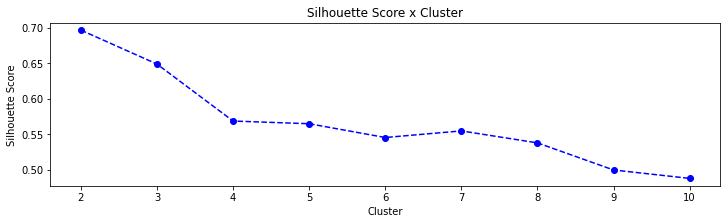

In [239]:
plt.figure(figsize=(12,3));
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b');
plt.xlabel('Cluster');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x Cluster');


In [251]:
gmm_list=[]

for k in clusters:
    #model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    #model training
    gmm_model.fit(X)

    #model predict
    labels = gmm_model.predict(X)

    #model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

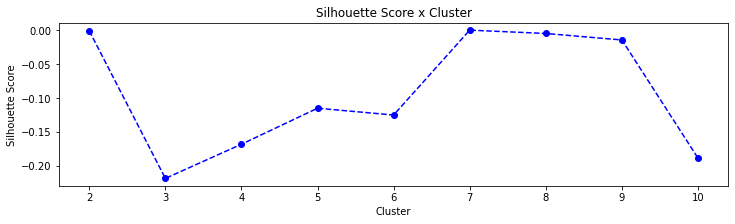

In [252]:
plt.figure(figsize=(12,3));
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b');
plt.xlabel('Cluster');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x Cluster');

In [242]:
hc_list = []

for k in clusters:
    #model definition & training
    hc_model = hc.linkage(X, 'ward')


    #model predict
    labels = hc.fcluster(hc_model,k, criterion='maxclust')

    #model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

In [243]:
# hc.dendrogram(hc_model, leaf_rotation=90, leaf_font_size=8);
# plt.figure(figsize=(20,12));
# plt.show();

In [244]:
df_results = pd.DataFrame({'KMeans': kmeans_list, 'GMM': gmm_list, 'HC': hc_list}).T
df_results.columns = clusters
df_results = df_results.style.highlight_max(color='lightgreen', axis=1)
df_results

,2,3,4,5,6,7,8,9,10
KMeans,0.696954,0.649030,0.568581,0.564766,0.545307,0.554623,0.537734,0.499457,0.487581
GMM,-0.000701,-0.213357,-0.168050,-0.114919,-0.112972,-0.127942,-0.056956,0.066164,-0.136097
HC,0.664325,0.642406,0.540601,0.494769,0.481611,0.493750,0.498828,0.514570,0.479386


In [228]:
X = df_tree.copy()
X.head()

,embedding_x,embedding_y
0,-0.646343,15.983326
1,-1.402045,5.210173
2,-0.028806,13.853423
3,4.755266,15.093255
4,6.588394,-8.239231


In [229]:
clusters = np.arange(2,11, 1)

kmeans_list = []
for k in clusters:

    #model definition
    kmeans_model = c.KMeans(n_clusters=k, random_state=42)

    #model training
    kmeans_model.fit(X)

    #model predict
    labels = kmeans_model.predict(X)

    #model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

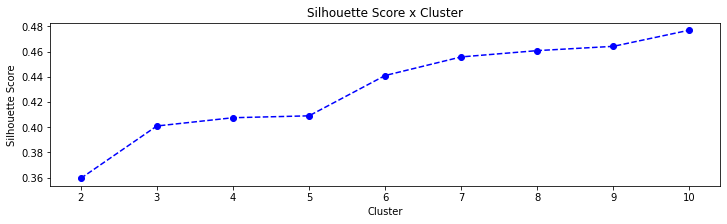

In [230]:
plt.figure(figsize=(12,3));
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b');
plt.xlabel('Cluster');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x Cluster');


In [231]:
gmm_list=[]

for k in clusters:
    #model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    #model training
    gmm_model.fit(X)

    #model predict
    labels = gmm_model.predict(X)

    #model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

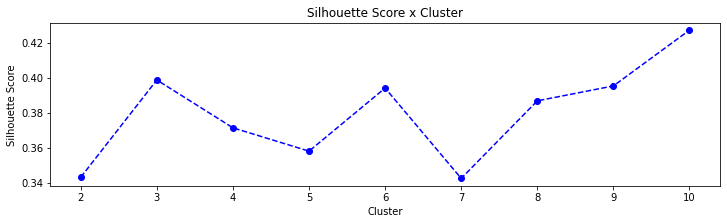

In [232]:
plt.figure(figsize=(12,3));
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b');
plt.xlabel('Cluster');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x Cluster');

In [233]:
hc_list = []

for k in clusters:
    #model definition & training
    hc_model = hc.linkage(X, 'ward')


    #model predict
    labels = hc.fcluster(hc_model,k, criterion='maxclust')

    #model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    hc_list.append(sil)

In [234]:
# hc.dendrogram(hc_model, leaf_rotation=90, leaf_font_size=8);
# plt.figure(figsize=(20,12));
# plt.show();

In [235]:
df_results2 = pd.DataFrame({'KMeans': kmeans_list, 'GMM': gmm_list, 'HC': hc_list}).T
df_results2.columns = clusters
df_results2 = df_results2.style.highlight_max(color='lightgreen', axis=1)
df_results2

,2,3,4,5,6,7,8,9,10
KMeans,0.359386,0.400959,0.407516,0.409021,0.441009,0.455770,0.460765,0.464167,0.477022
GMM,0.343271,0.398690,0.371425,0.358135,0.394084,0.342607,0.386802,0.395304,0.427105
HC,0.337276,0.359488,0.384541,0.396333,0.418948,0.424139,0.441488,0.448843,0.450834


## 8.2. GMM

In [255]:
# model definition
k = 8
X=df43.copy()
# ## model definition
# gmm_model = mx.GaussianMixture( n_components=k )


# # gmm_model = pickle.load(open('../models/gmm_model.pickle', 'rb'))
# # model training
# gmm_model.fit( X )

# # model predict
# labels = gmm_model.predict( X )

#model definition
kmeans_model = c.KMeans(n_clusters=k, random_state=42)

#model training
kmeans_model.fit(X)

#model predict
labels = kmeans_model.predict(X)

#model performance
sil = m.silhouette_score(X, labels, metric='euclidean')
kmeans_list.append(sil)



In [256]:
m.silhouette_score(X, labels, metric='euclidean')

0.5377337303161348

# 9.0. Cluster Analisys

In [262]:
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qt_products', 'frequency', 'qt_returns']
df9 = X.copy()
df9['cluster'] = labels


## 9.2. Cluster Profile

In [263]:

df92 = df4[cols_selected].copy()


df92['cluster']= labels

 # Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_qtde_products = df92[['qt_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_qtde_returns = df92[['qt_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster' )

df_cluster.sort_values( 'gross_revenue', ascending=False )

# df92.columns

# aux0 = df92[['customer_id', 'cluster']].groupby('cluster').count().reset_index()


# # aux1 = aux1.drop('customer_id', axis=1)
# df92 = df92[['gross_revenue', 'recency_days', 'qt_products', 'frequency', 'qt_returns', 'cluster']].groupby('cluster').mean().reset_index()
# df92 = pd.merge(df92, aux0, on='cluster', how='left')



,cluster,customer_id,perc_customer,gross_revenue,recency_days,qt_products,frequency,qt_returns
7,7,12,0.210711,121078.380833,4.333333,2773.916667,0.241589,824.000000
2,2,2043,35.873573,2674.933000,16.053353,138.710720,0.037982,32.131669
0,0,1115,19.578578,1091.372691,61.211659,65.326457,0.018796,8.379372
5,5,401,7.041264,1086.688304,352.501247,74.957606,0.093306,187.448878
4,4,539,9.464442,937.796030,115.391466,60.517625,0.015304,4.294991
6,6,492,8.639157,711.013984,229.662602,43.579268,0.014024,22.392276
3,3,577,10.131694,695.872149,172.798960,53.883882,0.022967,3.665511
1,1,516,9.060579,537.556066,287.897287,43.974806,0.008170,5.005814


# 10.0. Deploy to Production

In [265]:
df10 = df4[cols_selected].copy()
df10['cluster'] = labels

In [266]:
df_aux = df10[['qt_products', 'cluster']].groupby('cluster').sum().reset_index()

#total products
total = df10['qt_products'].sum()

#insiders products
df_aux_insider = df_aux.loc[df_aux['cluster']==6, 'qt_products']

print('% Sales Insiders: {:.2f}%'.format((total - df_aux_insider.sum())/total*100))

% Sales Insiders: 95.93%


In [267]:
df_aux = df10[['gross_revenue', 'cluster']].groupby('cluster').sum().reset_index()

#total products
total = df10['gross_revenue'].sum()

#insiders products
df_aux_insider = df_aux.loc[df_aux['cluster']==6, 'gross_revenue']

print('% GMV Insiders: {:.2f}%'.format((total - df_aux_insider.sum())/total*100))

% GMV Insiders: 96.54%


In [270]:
insider = df_cluster.loc[df_cluster['cluster']==6, 'qt_returns'].mean()

total = df_cluster['qt_returns'].mean()



print('% de retornos de insiders em relação ao total {:.0f}%'.format((total-insider)/total*100))

% de retornos de insiders em relação ao total 84%


In [271]:
df_aux = df10[['gross_revenue', 'cluster']].groupby('cluster').median().reset_index()

#total products
total = df10['gross_revenue'].median()

#insiders products
df_aux_insider = df_aux.loc[df_aux['cluster']==6, 'gross_revenue']
median = df_aux_insider.median()

print('Mediana GMV total: {:.2f}'.format(total))

print('Mediana GMV Insiders: {:.2f}'.format(df_aux_insider.median()))

print('Diferença: {:.0f}% maior nos Insiders'.format((median-total)/total*100))

Mediana GMV total: 613.20
Mediana GMV Insiders: 351.06
Diferença: -43% maior nos Insiders


In [291]:
df10[df10['cluster'] == 7].sort_values('gross_revenue', ascending=False)

,customer_id,gross_revenue,recency_days,qt_products,frequency,qt_returns,cluster
1017,14646,279138.02,1.0,2060.0,0.203966,288.0,7
492,18102,259657.30,0.0,431.0,0.163488,0.0,7
433,17450,194550.79,8.0,337.0,0.128134,952.0,7
66,14911,140450.72,1.0,5673.0,0.534946,3332.0,7
1150,12415,124564.53,24.0,713.0,0.063898,427.0,7
190,14156,117379.63,9.0,1400.0,0.151934,859.0,7
15,17511,91062.38,2.0,963.0,0.083558,1535.0,7
8,15311,60767.90,0.0,2379.0,0.243968,474.0,7
278,13089,58825.83,2.0,1818.0,0.264305,283.0,7
4405,14096,53258.43,4.0,5095.0,0.175258,0.0,7


/home/heitor/repos/insiders_clustering/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='quantity', ylabel='Density'>

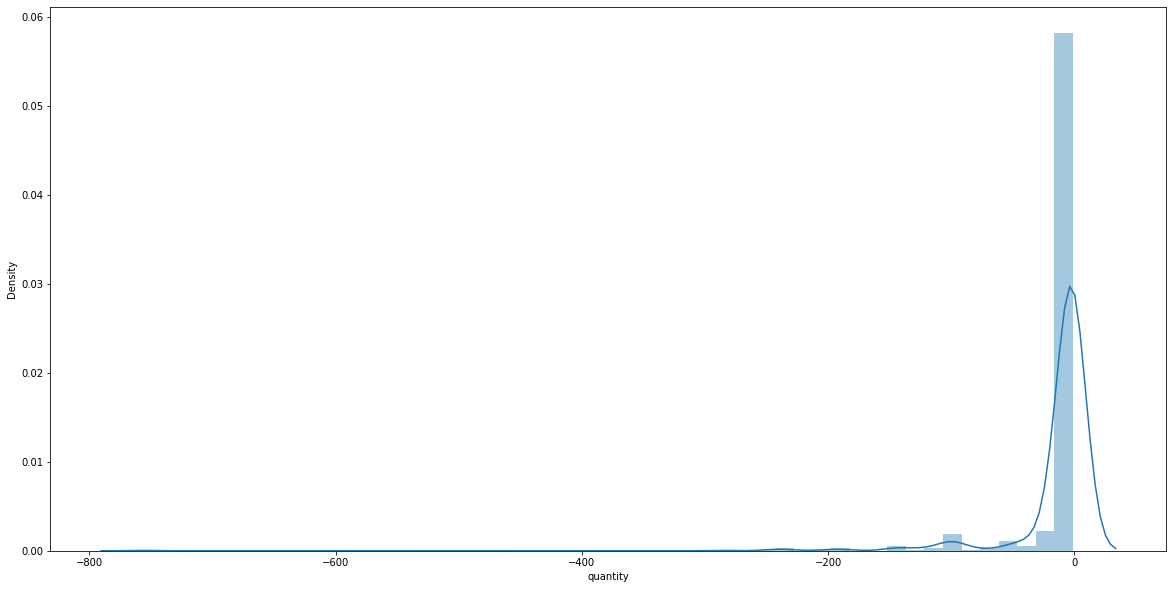

In [290]:
df_merge = pd.merge(df2, df10[['cluster','customer_id']], on='customer_id', how='left')
df_merge = df_merge.dropna()

df_aux = df_merge.loc[(df_merge['quantity']<0) & (df_merge['cluster']==7),:]

plt.figure(figsize=(20,10))
sns.distplot(df_aux['quantity'])

In [ ]:
df10.dtypes

Faturamento retornado em devolução: 1.0%
